# Modeling

This notebook aims at analyzing two steps of the project: 

1. **SVD Training and Validation**

    - Perform a SVD recommendation using the [FunkSVD](https://github.com/gbolmier/funk-svd) algorithm. In particular, rows are users and columns are the provided offers. Values in the matrix (which would be ratings) are the mean reward obtained for each user for the associated offer. 
    
    - Analize the number of factors to use in SVD
    
    - Extracts prediction accuracy (RMSE, MAE) and usage (Precision@k, Recall@k) metrics. 

2. **Cluster Training and Validation**

    - Perform K-means clustering on the predicted utility matrix from the SVD algorithm. However, relevant users' features such as `income` are also added to the clustering training set.
    
    - Analyze the number $k$ of centroids to use based on sillhouette score

3. **MAB Training and Validation**
    
    - Utilize a MAB for each cluster in order to choose which offer to recommend
    
    - Analyze product diversity


## Imports and Data Loading

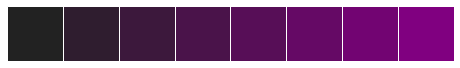

In [82]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score    
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
from funk_svd.svd import SVD
import mab
import joblib
import pickle
import boto3
from IPython.display import clear_output
data_dir = './../data'
plots_dir = './plots/'
progbar = utils.ProgressBar(elapsed_time=True)

config = utils.load_json_file(os.path.join(sources_path, "config.json"))

palette = config["palette"]
second_palette = config["custom_palette"]

sns_palette = sns.dark_palette(palette, n_colors=8)
sns.palplot(sns_palette)
sns.set_palette(sns_palette)
sns.set(font_scale=1.2)

In [3]:
profile = pd.read_csv(os.path.join(data_dir, "profile.csv"), sep=';', usecols=["person", "income"])
profile = profile.set_index(["person"])
df_offers = pd.read_csv(os.path.join(data_dir, 'df_offers.csv'), sep=';')

## 1. SVD Training and Validation

In [5]:
df_offers.head()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,bogo,informational,discount,offered_reward,age,became_member_on,gender,income,days_since_subscription,reward
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1,24,0,NaN,0.00,1,0,...,0,1,0,0,33.0,2017-04-21,M,72000.0,1102,1
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1,36,0,NaN,0.00,1,0,...,0,1,0,0,33.0,2017-04-21,M,72000.0,1102,1
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1,48,1,6.0,8.57,0,1,...,1,0,0,5,33.0,2017-04-21,M,72000.0,1102,8
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1,36,1,24.0,14.11,0,1,...,0,0,1,2,33.0,2017-04-21,M,72000.0,1102,5
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1,36,1,0.0,10.27,0,1,...,0,0,1,2,33.0,2017-04-21,M,72000.0,1102,5


In [34]:
df_ratings = df_offers[["person", "offer_id", "reward"]].copy()
df_ratings.rename({"person": "u_id", "offer_id": "i_id", "reward": "rating"}, axis=1, inplace=True)
df_ratings = df_ratings.groupby(["u_id", "i_id"]).mean().reset_index()

### N Factors Sweep

By running a 5 fold cross validation, we shall analyze the most appropriate number of factors to use based on RMSE, MAE, Precision@k and Recall@k,

In [35]:
%%time
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_n_factors = [20, 40, 60, 80, 100, 150, 200]
k = config["top_k"]
threshold = config["reward_threshold"] # Minimum mean reward for the offer to be recommended

df_eval = pd.DataFrame(
    columns=["n_factors", "fold", 
            "train_mae", "val_mae", "test_mae", 
            "train_rmse", "val_rmse", "test_rmse",
            "train_prec_at_"+str(k), "val_prec_at_"+str(k), "test_prec_at_"+str(k),
            "train_recall_at_"+str(k), "val_recall_at_"+str(k), "test_recall_at_"+str(k)]
)

for n_factors in arr_n_factors:
    print ("Running analysis for {} factors".format(n_factors))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            n_factors, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row
        
clear_output()

CPU times: user 56.7 s, sys: 40.3 ms, total: 56.7 s
Wall time: 56.8 s


Plotting results

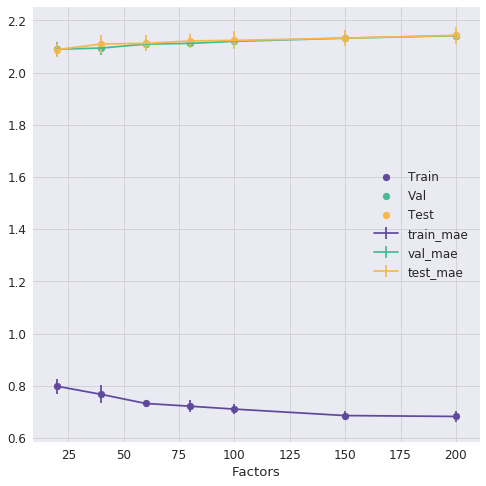

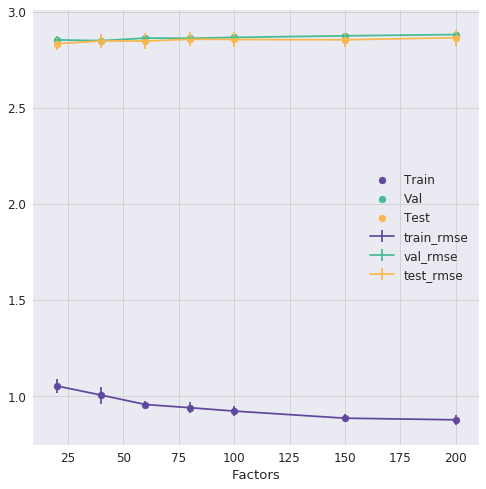

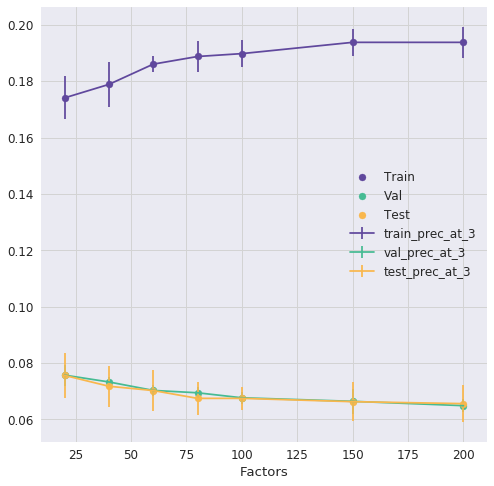

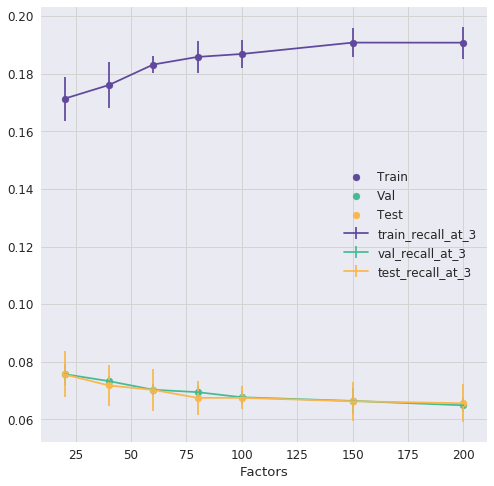

In [36]:
df_plot = df_eval.groupby(["n_factors"]).mean()
df_plot_std = df_eval.groupby(["n_factors"]).std()

for metric in ["mae", "rmse", "prec_at_" + str(k), "recall_at_" + str(k)]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i])
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Factors")
    ax.grid(True, color="lightgray")
    filename = "{}_factors_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

By leveraging all figures of merit, the number of factors to be chosen is $100$

In [19]:
n_factors = config["n_factors"]

### Top K Sweep

Now that we have established the number of factors, we can analyze how well the SVD performs in this algorithm for different recommendation ranks. 

In [ ]:
%%time
n_folds = config["n_folds"]
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_k = np.arange(1, df_offers["offer_id"].nunique()+1, 1)

df_eval = pd.DataFrame(columns=["k", "fold", 
                                "train_mae", "val_mae", "test_mae", 
                                "train_rmse", "val_rmse", "test_rmse",
                                "train_prec_at_k", "val_prec_at_k", "test_prec_at_k",
                                "train_recall_at_k", "val_recall_at_k", "test_recall_at_k"])

for k in arr_k:
    print ("Running analysis for k = {}".format(k))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            k, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row


CPU times: user 1min 51s, sys: 56.2 ms, total: 1min 51s
Wall time: 1min 51s


Plotting results

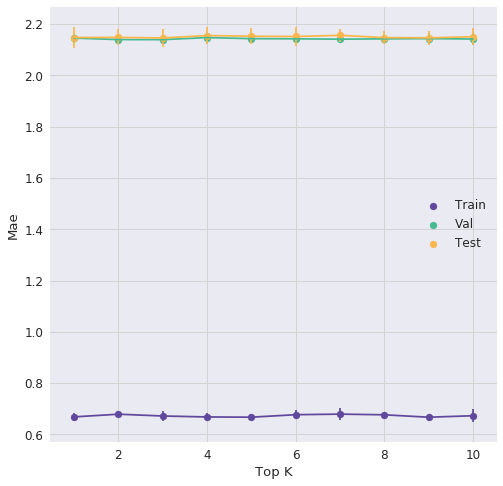

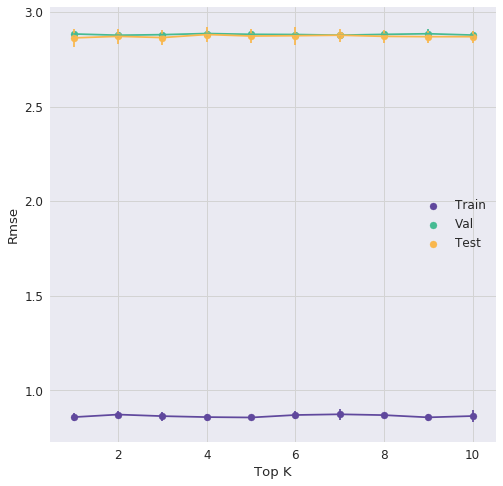

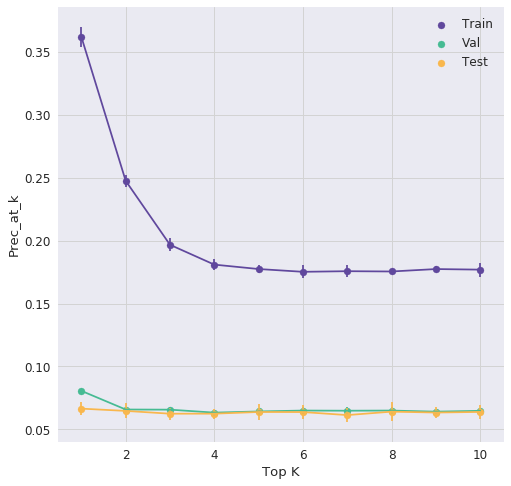

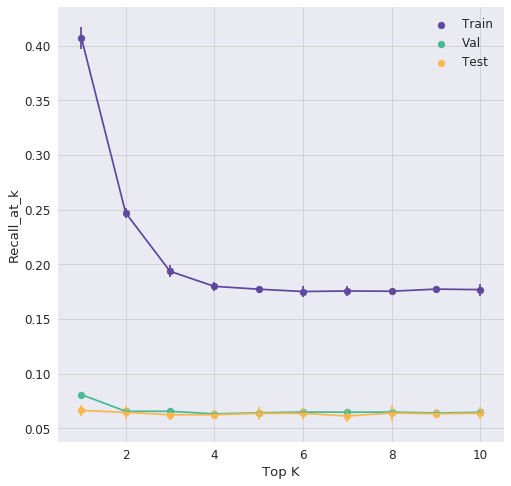

In [38]:
df_plot = df_eval.groupby(["k"]).mean()
df_plot_std = df_eval.groupby(["k"]).std()
for metric in ["mae", "rmse", "prec_at_k", "recall_at_k"]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i], label=None)
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Top K"), ax.set_ylabel(metric.capitalize())
    ax.grid(True, color="lightgray")
    filename = "{}_top_k_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

From the analysis above, we can check that RMSE and MAE are not greatly affected by ranking. This is expected since the number of recommended items are not taken into consideration for these prediction accuracy measures. 

However, we can see that the algorithm performs at its best for both Precision@k and Recall@k when $k = 1$. This leads to the conclusion that a short-term recommendation is suited for the algorithm, meaning it can predict which item shall be consumed next. 

In [39]:
# Extracting fully-densed utility matrix
df_matrix_original = svd.get_utility_matrix(df_ratings)

# Getting all u_id and i_id combinations
df_predictions= pd.melt(df_matrix_original.reset_index(drop=False), id_vars='u_id')
df_predictions.rename({"value": "rating"}, axis=1, inplace=True)

Prediction rewards for every possible user-item pair

In [40]:
df_predictions["rating"] = svd.predict(df_predictions, clip=False)
df_matrix_predictions = svd.get_utility_matrix(df_predictions)
# df_matrix_predictions.to_csv(os.path.join(data_dir, "df_matrix_predictions.csv"), sep=';', index=None)

## 2. Clustering

Now that we have a fully densed utility matrix, we shall remember that most matrix factorization techniques require that users or items latent factors are trained. This is particularly inconvenient for new users or items, since their latent factors are unknown. 

In order to tackle this problem, we shall cluster users based on the fully-densed matrix. Once they are clustered, the centroid are used on the following MAB algorithm. 

In [41]:
# Including users' income as a clustering column
df_cluster = pd.merge(profile, df_matrix_predictions, how="inner", left_index=True, right_index=True)

Analyzing silhouette score for multiple number of clusters

In [42]:
silhouette_avg = list()
arr_n_clusters = np.arange(2, 20, 1)
X = df_cluster.values#.drop(["gender", "became_member_on", "days_since_subscription", "age", "gender_clean"], axis=1).values
df_silhouette_avg = pd.DataFrame(columns = ["fold", "n_cluster", "train_silhouette", "test_silhouette"])
trained_models = list()

for fold, [train_index, val_index] in enumerate(ss.split(X)):
    
    print ("Running analysis on fold {}".format(fold))
    X_train, X_val = X[train_index], X[val_index]
    
    for n_cluster in arr_n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X_train)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        val_silhouette = silhouette_score(X_val, model.predict(X_val))

        row = [fold, n_cluster, train_silhouette, val_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row   

Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


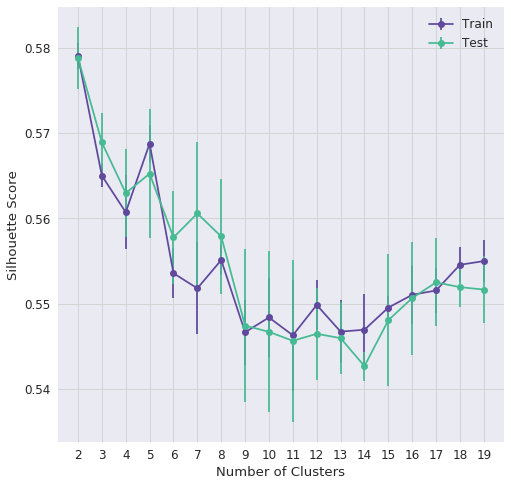

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
df_plot = df_silhouette_avg.groupby("n_cluster")
for i, set_label in enumerate(["train", "test"]):
    ax.errorbar(df_plot.mean().index, 
                df_plot.mean()[set_label + "_silhouette"].values, 
                df_plot.std()[set_label + "_silhouette"].values, label=set_label.title(),
               marker='o', mec='black', color = second_palette[i])
ax.set_xticks(arr_n_clusters), ax.set_xticklabels(arr_n_clusters)

ax.grid(True, color="lightgray")
ax.legend()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
filename = "silhouette_score.jpg"
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

Considering the silhouette score, a proper number of clusters would be $5$

In [48]:
import sagemaker
# from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = sagemaker.get_execution_role()
print (role)

arn:aws:iam::595380434278:role/service-role/AmazonSageMaker-ExecutionRole-20200314T155204


In [53]:
bucket = session.default_bucket()
prefix = "sagemaker/capstone"

output_path='s3://{}/{}/'.format(bucket, prefix)

### Training the final K-Means model

In [237]:
n_clusters = config["n_clusters"]
model = KMeans(n_clusters=n_clusters, random_state=0, verbose=False)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=False)

### Defining clusters rewards

In [245]:
df_clusters_rewards = pd.DataFrame(model.cluster_centers_)
df_clusters_rewards.columns = df_cluster.columns
df_clusters_rewards = df_clusters_rewards.reset_index(drop=False).rename({"index": "cluster"},axis=1).set_index("cluster")
df_clusters_rewards.drop(["income"], axis=1, inplace=True)
df_clusters_rewards.to_csv(os.path.join(data_dir, "df_clusters_rewards.csv"), sep=';')
df_clusters_rewards

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
cluster,,,,,,,,,,
0,4.468944,4.353112,3.171796,1.158738,6.607949,1.156214,5.077485,7.090105,4.945140,3.826660
1,3.602068,3.876522,2.749256,1.141572,5.163500,1.140838,4.345589,5.648109,4.298244,3.407127
2,4.924493,4.531830,3.364043,1.163950,7.216156,1.160483,5.366338,7.824228,5.209756,4.003827
3,4.121135,4.171373,3.004239,1.151669,6.082074,1.149896,4.769139,6.525320,4.715630,3.659484
4,4.940099,4.563407,3.360691,1.164853,7.379129,1.161984,5.373086,7.761143,5.249557,4.023505


## 3. Multi-Armed Bandit

Now that we have the mean reward for each cluster, we can model them as a multi-armed bandit (MAB). Each cluster shall be considered as a MAB and each product is an arm to be pulled. 

Many algorithms have been proposed as a MAB. For this project, we will use the $\epsilon$-greedy-decay algorithm because we want to explore in the begining and then slowly start exploiting the most rewarding arms. 

However, a slight modification has been made to the algorithm. Since there are few products and we don't want users to always receive the same recommendation, a threshold $\epsilon$ has been set to guarantee a minimum exploration when the optimization converges. In other words, the $\epsilon$ parameter starts with a high value and, as the epochs continue, it keeps decreasing until it reaches a threshold where it remains with a fixed value. 

In [85]:
from mab.greedy import EGreedyDecay

In [246]:
%%time

T = 30000
realizations = 20
epsilon = config["epsilon"]
beta = config["beta"]
print ('Starting MAB Experiment')

mean_reward_hist = pd.DataFrame(columns=[i for i in np.arange(T+1)] + ["realization"])

for realization in np.arange(realizations):
    progbar.update_progress(realization/realizations)
    last_reward = np.zeros(n_clusters)
    bandits = [EGreedyDecay(epsilon=epsilon, beta=beta) for _ in np.arange(n_clusters)]
    for i in np.arange(n_clusters):
        bandits[i].set_rewards(df_clusters_rewards.loc[i])

    temp_mean_reward_hist = dict()
    for cluster in np.arange(n_clusters):
        temp_mean_reward_hist[cluster] = []

    for t in range(1,T):
        for cluster in np.arange(n_clusters):
            item = bandits[cluster].pull_arm(last_reward[cluster]) 
            last_reward[cluster] = bandits[cluster].get_reward(item) 
            temp_mean_reward_hist[cluster].append(bandits[cluster].mean_reward)

    temp_mean_reward_hist = pd.DataFrame(temp_mean_reward_hist).T
    temp_mean_reward_hist["realization"] = realization
    mean_reward_hist = pd.concat([mean_reward_hist, temp_mean_reward_hist], sort=False)
    
mean_reward_hist = mean_reward_hist.reset_index(drop=False).rename({"index": "cluster"}, axis=1)

Starting MAB Experiment
[0:01:09][##########] 95.00% CPU times: user 1min 14s, sys: 152 ms, total: 1min 14s
Wall time: 1min 14s


Saving file at  EGreedyDecay_mean_average_reward_20_realizations.jpeg


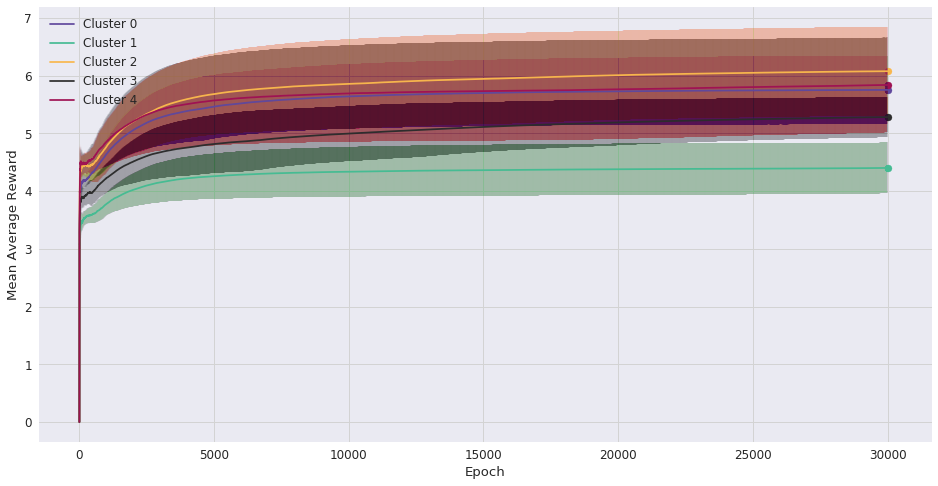

In [247]:
fig, ax = plt.subplots(figsize=(16,8))
df_plot_mean = mean_reward_hist.groupby(["cluster"]).mean()#[np.arange(0, T, 2000)]
df_plot_std = mean_reward_hist.groupby(["cluster"]).std()#[np.arange(0, T, 2000)]
for cluster in np.arange(n_clusters):
    ax.plot(df_plot_mean.iloc[cluster], 
            label = "Cluster " + str(cluster), 
            color=second_palette[cluster], alpha=5)
    
    ax.errorbar(df_plot_mean.columns,
                df_plot_mean.iloc[cluster],                
                df_plot_std.iloc[cluster], 
           color=second_palette[cluster], 
               alpha=.002, label=None)
    
    ax.scatter(x=[T], y=[np.array(df_plot_mean.loc[cluster])[-1]], 
               color=second_palette[cluster], label=None)
    
ax.set_xlabel("Epoch"), ax.set_ylabel("Mean Average Reward")
ax.legend()
ax.grid(True, color="lightgray")
filename = "{}_mean_average_reward_{}_realizations.jpeg".format(str(bandits[0]), realizations)
print ("Saving file at ", filename)
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

The above figure let us analyze the convergence behaviour for each MAB.

6 [  993.   939.  1020.   943.   930.   935. 20862.   937.  1483.   957.]
4 [  988.   931.   947.   979. 21376.   939.   980.   997.   927.   935.]
7 [  928.   928.  1188.   990.   945.   938.   915. 21234.   959.   974.]
4 [  917.   989.   993.   953. 21403.   986.   920.   944.   955.   939.]
6 [ 1018.   935.   975.   974.   953.  1002. 21030.   992.  1159.   961.]


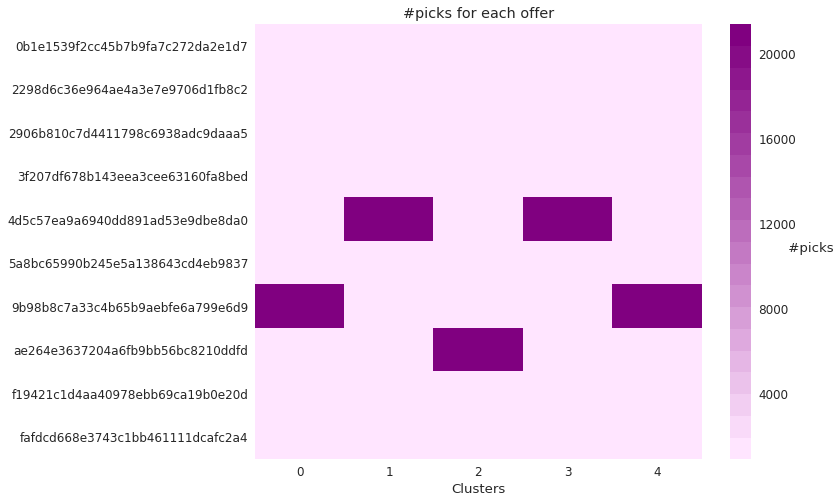

In [248]:
picks = np.zeros([n_clusters, bandits[0].k])
for cluster, bandit in enumerate(bandits):
    picks[cluster] = bandit.k_n
    print (np.argmax(bandit.k_n), bandit.k_n)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(picks.T, ax=ax, cmap=sns.light_palette(palette, n_colors=20))
ax.set_xlabel("Clusters")
ax.set_yticklabels([product for product in df_clusters_rewards.columns], rotation = 0)
ax.collections[0].colorbar.set_label("     #picks", rotation=0)
ax.set_title("#picks for each offer")
filename = "picks_by_cluster.jpg"
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

The heatmap analysis let us infer whether a single product is being highly recommended by all clusters. In this case, we are only recommending a "blockbuster" item, which is not desirable since we want personalized recommendations. 


### Saving Models

In [249]:

with open(os.path.join(data_dir, os.path.join(data_dir, "trained_svd.pkl")), 'wb') as file: 
    pickle.dump(svd, file)

with open(os.path.join(data_dir, os.path.join(data_dir, "trained_kmeans.pkl")), 'wb') as file: 
    pickle.dump(model, file)

for cluster, bandit in enumerate(bandits):
    joblib.dump(bandit, os.path.join(data_dir, "trained_mab", "trained_{}_cluster_{}.joblib".format(str(bandit), cluster)))
    with open(os.path.join(data_dir, "trained_mab", "trained_{}_cluster_{}.pkl".format(str(bandit), cluster)), 'wb') as file: 
        pickle.dump(bandit, file)

In [250]:
session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print ("Data Uploaded")

Data Uploaded


## Testing Recommendation

In [252]:
cred = session.boto_session.get_credentials()
s3client = boto3.client(
    's3', 
    aws_access_key_id = cred.access_key, 
    aws_secret_access_key = cred.secret_key, 
    aws_session_token = cred.token
)

In [266]:
prefix

'sagemaker/capstone'

In [264]:
user_features = df_cluster.sample().values.astype('float')
print (user_features)

[array([5.20000000e+04, 5.13409054e+00, 3.87748952e+00, 3.92481188e+00,
       1.24089843e+00, 6.41888152e+00, 1.23871500e+00, 5.85716189e+00,
       7.57804149e+00, 4.96265837e+00, 4.23194230e+00])]


### Getting KMeans

In [253]:
response = s3client.get_object(Bucket=bucket, Key=os.path.join(prefix, 'trained_kmeans.pkl'))#.decode('utf8')
body = response['Body'].read()
kmeans = pickle.loads(body)

In [258]:
cluster = kmeans.predict(user_features)[0]
print ("User cluster: ", cluster)

User cluster:  3


### Getting cluster MAB

In [259]:
response = s3client.get_object(Bucket=bucket, Key=os.path.join(prefix, 'trained_mab/trained_EGreedyDecay_cluster_{}.pkl'.format(cluster)))#.decode('utf8')
body = response['Body'].read()
model = pickle.loads(body)

### Getting Recommendation

In [260]:
model.pull_arm(1)

'4d5c57ea9a6940dd891ad53e9dbe8da0'